### References
- Original Kaggle Notebook: https://www.kaggle.com/code/shivamb/3d-convolutions-understanding-use-case
- Dataset: https://www.kaggle.com/code/shivamb/3d-convolutions-understanding-use-case/input

In [1]:
# !pip install --upgrade tensorflow keras numpy
# !pip install --upgrade scikit-learn
# !pip install --upgrade matplotlib plotly
# %pip install --upgrade nbformat>4.2.0
# %pip install seaborn
# %pip install pydot

In [ ]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, balanced_accuracy_score, matthews_corrcoef
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from matplotlib.pyplot import cm
from keras.utils import plot_model
from keras.models import Model
import numpy as np
import keras
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

init_notebook_mode(connected=True)
%matplotlib inline
%load_ext tensorboard

3D MNIST is in h5 format

In [4]:
with h5py.File('data/3d_mnist.h5', 'r') as dataset:
    x_train = dataset['X_train'][:]
    x_test = dataset['X_test'][:]
    y_train = dataset['y_train'][:]
    y_test = dataset['y_test'][:]

In [5]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (10000, 4096)
y_train shape: (10000,)
x_test shape: (2000, 4096)
y_test shape: (2000,)


The dataset is flat 1D data, however the author shared the original x, y, in a separate data file. Plotting this in 3D space.

In [6]:
x_train[0].shape

(4096,)

In [7]:
with h5py.File("data/train/train_point_clouds.h5", "r") as dataset:
    digits = []
    for i in range(10):
        digit = (dataset[str(i)]["img"][:],
                dataset[str(i)]["points"][:],
                dataset[str(i)].attrs["label"])
        digits.append(digit)
#       (30, 30), (25700, 3), 1
# print(digits[0][0].shape, digits[0][1].shape, digits[0][2].shape)

x_c = [r[0] for r in digits[0][1]]
y_c = [r[1] for r in digits[0][1]]
z_c = [r[2] for r in digits[0][1]]

trace1 = go.Scatter3d(x=x_c, y=y_c, z=z_c, mode='markers', marker=dict(size=12, color=z_c, colorscale='Viridis', opacity=0.8))

data = [trace1]

layout = go.Layout(height=500, width=600, title="Digit: " + str(digits[0][2]) + " in 3D Space")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Now implementing a 3D CNN on this dataset. To use 2D convolutions, the images must be converted into a 3D shape: width, height and channels. Channels are RGB (3). Now to use 3D convolutions we convert need the dataset to be 4D, namely length, breadth, height and channels.

In [8]:
# Introducing the channel dimension in the input dataset
xtrain = np.ndarray((x_train.shape[0], 4096, 3))
xtest = np.ndarray((x_test.shape[0], 4096, 3))

# Iterate in train and test and add the channel dimension
def add_rgb_dimension(array):
    scalar_map = cm.ScalarMappable(cmap="Oranges")
    array = scalar_map.to_rgba(array)[:, :-1]
    # print(array.shape) # (4096, 2, 4)
    return array

for i in range(x_train.shape[0]):
    xtrain[i] = add_rgb_dimension(x_train[i])
for i in range(x_test.shape[0]):
    xtest[i] = add_rgb_dimension(x_test[i])

# Convert to 1 + 4D space (1st argument represents the number of rows in the dataset)
xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

# Convert the target variable into a one-hot encoding vector
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(xtrain.shape, xtest.shape)
print(y_train.shape, y_test.shape)

(10000, 16, 16, 16, 3) (2000, 16, 16, 16, 3)
(10000, 10) (2000, 10)


## Creating the model architecture

### Input and output layers:
    - One input layer with dimensions 16, 16, 16, 3
    - Output layer with dimension of 10

### Convolutions
    - Apply 4 Convolutional layers with increasing order of filter size (standard size: 8, 16, 32, 64) and fixed kernel size of (3, 3, 3)
    - Apply 2 Max Pooling layers, one after the 2nd convolutional layer and one after the fourth convolutional layer

### MLP Architecture:
    - Batch Normalization on Convolutional Architecture
    - Dense layers with 2 layers followed by dropout to avoid overfitting

In [3]:
input_layer = Input((16, 16, 16, 3))

# Convolutional Layer 1
conv_layer1 = Conv3D(
    filters=8,
    kernel_size=(3,3,3),
    activation='relu'
)(input_layer)
# Convolutional Layer 2
conv_layer2 = Conv3D(
    filters=16,
    kernel_size=(3,3,3),
    activation='relu'
)(conv_layer1)

# Pooling Layer to obtain most informative features
pooling_layer1 = MaxPool3D(
    pool_size=(2,2,2)
)(conv_layer2)

# Convolutional Layer 3
conv_layer3 = Conv3D(
    filters=32,
    kernel_size=(3,3,3),
    activation='relu'
)(pooling_layer1)
# Convolutional Layer 4
conv_layer4 = Conv3D(
    filters=64,
    kernel_size=(3,3,3),
    activation='relu'
)(conv_layer3)

# Pooling Layer
pooling_layer2 = MaxPool3D(
    pool_size=(2,2,2)
)(conv_layer4)

# Perform batch normalization on convolutional outputs before feeding it to the fully connected network
pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

# Create MLP architecture with dense layers: 2048 -> 512 -> 10
# add dropout to avoid overfitting / perform regularization
dense_layer1 = Dense(
    units=2048,
    activation='relu'
)(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)

dense_layer2 = Dense(
    units=512,
    activation='relu'
)(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)

output_layer = Dense(
    units=10,
    activation='softmax'
)(dense_layer2)

# Define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
# model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 16, 16, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 14, 14, 14, 8)  │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 12, 12, 12, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 6, 6, 6, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 4, 4, 32)    │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 2, 2, 2, 64)    │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 1, 1, 1, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 1, 1, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,260,938 (4.81 MB)

 Trainable params: 1,260,810 (4.81 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
plot_model(model, to_file="images/model_architecture_1.png", show_shapes=True, show_layer_names=True)

In [11]:
model.compile(
    loss=categorical_crossentropy,
    optimizer=Adadelta(learning_rate=0.1),
    metrics=['acc']
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(
    x=xtrain,
    y=y_train,
    batch_size=128,
    epochs=50,
    validation_split=0.2,
    callbacks=[tensorboard_callback]
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - acc: 0.1684 - loss: 2.2549 - val_acc: 0.1190 - val_loss: 2.2772
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - acc: 0.3848 - loss: 1.8317 - val_acc: 0.2210 - val_loss: 2.1614
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - acc: 0.5185 - loss: 1.4330 - val_acc: 0.2800 - val_loss: 2.0802
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - acc: 0.5742 - loss: 1.2315 - val_acc: 0.4190 - val_loss: 1.7834
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - acc: 0.5908 - loss: 1.1697 - val_acc: 0.5220 - val_loss: 1.5484
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - acc: 0.6304 - loss: 1.0689 - val_acc: 0.5240 - val_loss: 1.4030
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.6487 - loss: 1.0165 - val_acc: 0.6030 - val_loss: 1.2084
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - acc: 0.6491 - loss: 0.9873 - val_acc: 0.5785 - val_loss: 1.2318
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - acc: 0.6789

In [ ]:
%tensorboard --logdir logs/fit

Accuracy comments

In [41]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
pred

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([7, 7, 2, ..., 2, 7, 3])

### Metrics

In [42]:
accuracy_score_test = accuracy_score(y_test, pred)
print('Accuracy on test set:', y_test)

Accuracy on test set: [7 7 2 ... 8 9 9]


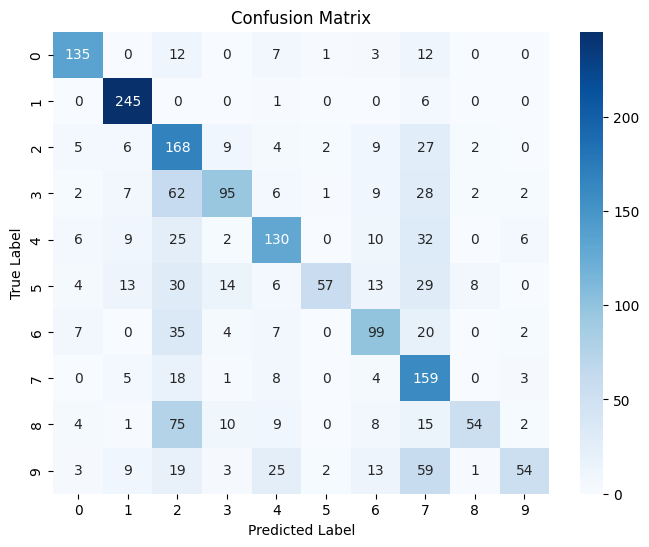

In [49]:
confusion_matrix_test = confusion_matrix(y_test, pred)
# Define class labels (adjust based on your dataset)
class_labels = [str(i) for i in range(10)]  # If working with digits 0-9

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [51]:
f1_score_test = f1_score(y_test, pred, average='weighted')
print('F1 Score:', f1_score_test)

F1 Score: 0.5889650577419365


In [53]:
balanced_accuracy_score_test = balanced_accuracy_score(y_test, pred)
print('Balanced Accuracy Score:', balanced_accuracy_score_test)

Balanced Accuracy Score: 0.5815498981107758


In [58]:
matthews_corrcoef_test = matthews_corrcoef(y_test, pred)
print("Matthews Correlation Coefficient:", matthews_corrcoef_test)

Matthews Correlation Coefficient: 0.560772855592979


In [63]:
classification_report_test = classification_report(y_test, pred)
print('Classification Report:', classification_report_test)

Classification Report:               precision    recall  f1-score   support

           0       0.81      0.79      0.80       170
           1       0.83      0.97      0.90       252
           2       0.38      0.72      0.50       232
           3       0.69      0.44      0.54       214
           4       0.64      0.59      0.61       220
           5       0.90      0.33      0.48       174
           6       0.59      0.57      0.58       174
           7       0.41      0.80      0.54       198
           8       0.81      0.30      0.44       178
           9       0.78      0.29      0.42       188

    accuracy                           0.60      2000
   macro avg       0.68      0.58      0.58      2000
weighted avg       0.68      0.60      0.59      2000



## Improved Network Architecture

- Increasing receptive fields with larger kernels initialy
- Adding strided convolutions instead of max pooling layers
- Using residual connections
- Applying squeeze and excite blocks
- Using Global Average Pooling(GAP) instead of flattening
- Use Layer Normalization instead of Group Normalization



In [6]:
from keras.layers import Input, Conv3D, MaxPool3D, GlobalAveragePooling3D, Dense, Dropout, Add, BatchNormalization, Activation
from keras.models import Model

def residual_block(x, filters):
    shortcut = x
    x = Conv3D(filters, kernel_size=(3,3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv3D(filters, kernel_size=(3,3,3), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

input_layer = Input((16, 16, 16, 3))

# Convolution layers with increasing filters
x = Conv3D(16, kernel_size=(5,5,5), activation='relu', padding='same')(input_layer)
x = residual_block(x, 16)
x = MaxPool3D(pool_size=(2,2,2))(x)

x = Conv3D(32, kernel_size=(3,3,3), activation='relu', padding='same')(x)
x = residual_block(x, 32)
x = MaxPool3D(pool_size=(2,2,2))(x)

x = Conv3D(64, kernel_size=(3,3,3), activation='relu', padding='same')(x)
x = residual_block(x, 64)

# Global Average Pooling
x = GlobalAveragePooling3D()(x)

# Dense layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Output Layer (10 Classes)
output_layer = Dense(10, activation='softmax')(x)

# Define model
model = Model(inputs=input_layer, outputs=output_layer)

# Prints model summary
# model.summary()

In [1]:
from keras.optimizers import AdamW
model.compile(
    loss=categorical_crossentropy,
    optimizer=Adadelta(learning_rate=0.1, weight_decay=1e-3),
    metrics=['acc']
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(
    x=xtrain,
    y=y_train,
    batch_size=128,
    epochs=50,
    validation_split=0.2,
    callbacks=[tensorboard_callback]
)

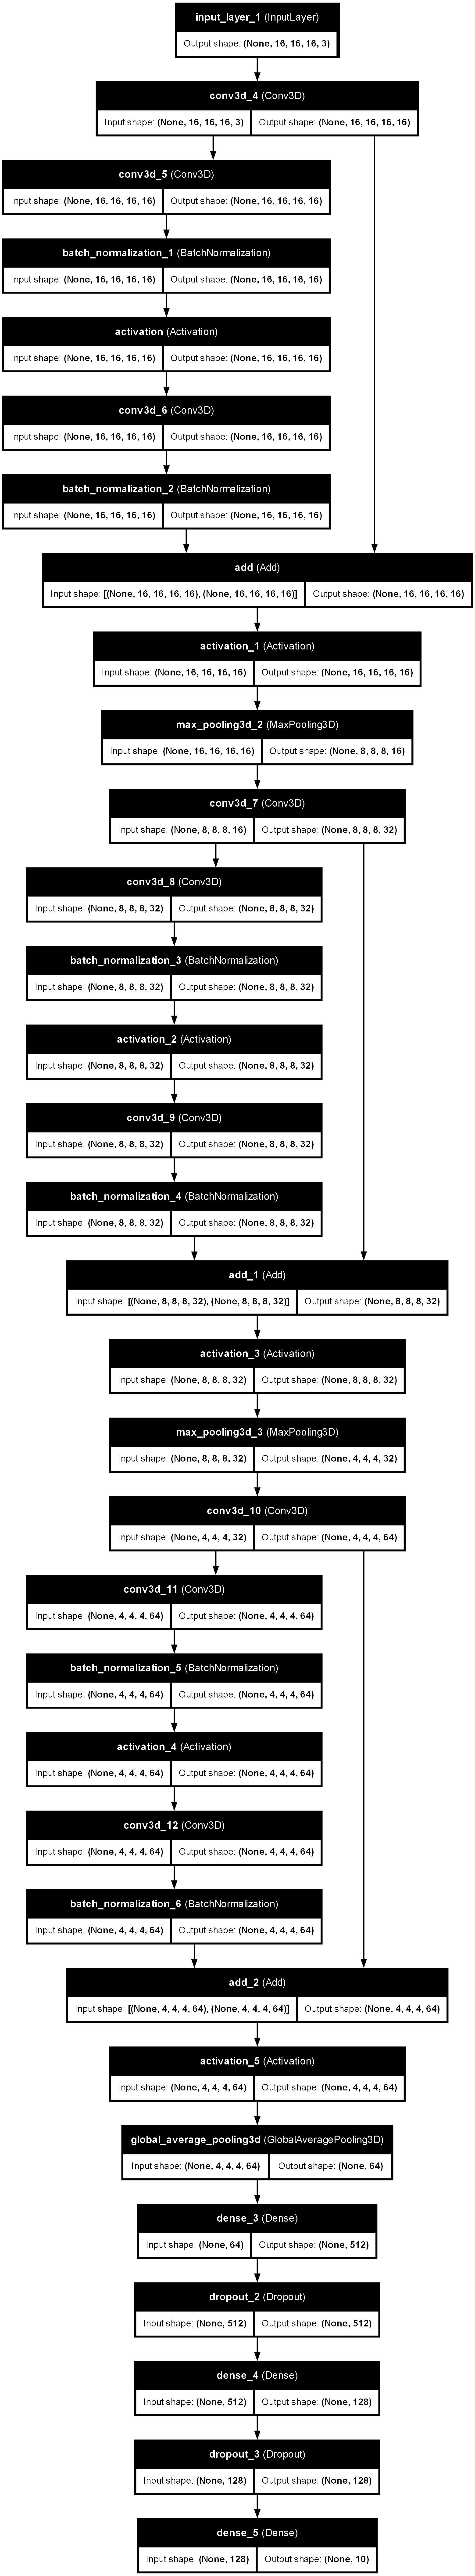

In [7]:
plot_model(model, to_file="images/model_architecture_2.png", show_shapes=True, show_layer_names=True)